# Imports and setting up libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# importing necessary libraries
import os
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms

In [4]:
!pip install torchinfo
from torchinfo import summary

In [5]:
os.chdir('/content/gdrive/MyDrive/Deep Learning/pytorch-experiments/Vision/')

In [6]:
# using GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
# ensuring reproducibility of code
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Loading data

In [8]:
arch = "densenetlike"

In [9]:
# some hyperparameters for the network
batch_size = 128
val_size = 0.1
epochs = 200
learning_rate = 3e-3
decay = 0.07
opt_milestones = [75, 115]

In [10]:
# defining transforms and data augmentation
train_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding = 4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))])

valid_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))])

In [11]:
# loading data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

validset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=valid_transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [12]:
# validation split
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(val_size * num_train))
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [13]:
# defining dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          sampler = train_sampler, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          sampler = valid_sampler, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle = False, num_workers=2)

In [14]:
# class names in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


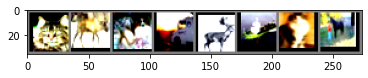

  cat  deer   dog truck  deer  ship   cat horse


In [15]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

# Network definitions

In [16]:
# importing model to be used
model_file = __import__(f'models.{arch}', fromlist=[arch])
base_arch = getattr(model_file, arch)

In [17]:
# moving net to GPU and summary of model architecture
net = base_arch()
net.to(device)
summary(net, input_size = (batch_size, 3, 32, 32), depth = 4)

Layer (type:depth-idx)                             Output Shape              Param #
densenetlike                                       --                        --
├─ModuleList: 1-1                                  --                        --
│    └─densechunk: 2                               --                        --
│    │    └─DenseBlock: 3                          --                        --
│    │    │    └─ModuleList: 4-1                   --                        26,496
│    │    │    └─ModuleList: 4-2                   --                        187,920
│    └─densechunk: 2                               --                        --
│    │    └─DenseBlock: 3                          --                        --
│    │    │    └─ModuleList: 4-3                   --                        40,320
│    │    │    └─ModuleList: 4-4                   --                        187,920
│    └─densechunk: 2                               --                        --
│    │    └─Dense

In [18]:
# defining loss, optimizer and lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr = learning_rate, weight_decay = decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, opt_milestones, gamma = 0.1)

# Training

In [19]:
def train(epoch):
    """training loop for one epoch"""
    net.train()

    running_loss = 0.0
    train_total = 0
    train_correct = 0

    for data in tqdm(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        running_loss += loss.item()
        predicted = torch.argmax(outputs.data, dim = 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # print statistics
    train_accuracy = 100 * (train_correct / train_total)
    print(f'    Loss of the network on the {train_total} training images: {running_loss}')
    print(f'    Accuracy of the network on the {train_total} training images: {train_accuracy}%')

In [20]:
def validation():
    """validation set evaluation for one epoch"""
    valid_correct = 0
    valid_total = 0

    # since we're not training, we don't need to calculate the gradients
    with torch.no_grad():
        net.eval()
        for data in validloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            predicted = torch.argmax(outputs.data, dim = 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

    valid_accuracy = 100 * (valid_correct / valid_total)
    print(f'    Accuracy of the network on the {valid_total} validation images: {valid_accuracy}%')

In [ ]:
# training

for epoch in range(epochs):  # loop over the dataset multiple times
    print("Epoch", epoch + 1)
    train(epoch)
    validation()
    print()
    scheduler.step()

print('Finished Training')

Epoch 1



    Loss of the network on the 45000 training images: 597.047896027565
    Accuracy of the network on the 45000 training images: 37.32888888888889%
    Accuracy of the network on the 5000 validation images: 46.82%

Epoch 2



    Loss of the network on the 45000 training images: 489.63057482242584
    Accuracy of the network on the 45000 training images: 49.248888888888885%
    Accuracy of the network on the 5000 validation images: 50.18%

Epoch 3



    Loss of the network on the 45000 training images: 426.3415342569351
    Accuracy of the network on the 45000 training images: 56.31777777777778%
    Accuracy of the network on the 5000 validation images: 57.379999999999995%

Epoch 4



    Loss of the network on the 45000 training images: 361.06570959091187
    Accuracy of the network on the 45000 training images: 63.519999999999996%
    Accuracy of the network on the 5000 validation images: 68.72%

Epoch 5



    Loss of the network on the 45000 training images: 309.1600390076637
    Accuracy of the network on the 45000 training images: 69.0111111111111%
    Accuracy of the network on the 5000 validation images: 72.08%

Epoch 6



    Loss of the network on the 45000 training images: 271.4645447731018
    Accuracy of the network on the 45000 training images: 73.13333333333333%
    Accuracy of the network on the 5000 validation images: 71.52%

Epoch 7



    Loss of the network on the 45000 training images: 242.03038448095322
    Accuracy of the network on the 45000 training images: 75.99555555555555%
    Accuracy of the network on the 5000 validation images: 77.32%

Epoch 8



    Loss of the network on the 45000 training images: 224.32519337534904
    Accuracy of the network on the 45000 training images: 77.8111111111111%
    Accuracy of the network on the 5000 validation images: 78.16%

Epoch 9



    Loss of the network on the 45000 training images: 211.79989621043205
    Accuracy of the network on the 45000 training images: 79.28%
    Accuracy of the network on the 5000 validation images: 79.17999999999999%

Epoch 10



    Loss of the network on the 45000 training images: 200.328861951828
    Accuracy of the network on the 45000 training images: 80.21111111111111%
    Accuracy of the network on the 5000 validation images: 74.96000000000001%

Epoch 11



    Loss of the network on the 45000 training images: 192.86415502429008
    Accuracy of the network on the 45000 training images: 81.04222222222222%
    Accuracy of the network on the 5000 validation images: 80.64%

Epoch 12


KeyboardInterrupt: ignored

In [ ]:
# saving model
model_save_name = f'cifar10{arch}.pt'
path = f"/content/gdrive/My Drive/Deep Learning/pytorch-experiments/Vision/CIFAR-10/trained models/{model_save_name}" 
torch.save(net, path)

# Testing

In [ ]:
# loading model
model_save_name = f'cifar10{arch}.pt'
PATH = f"/content/gdrive/My Drive/Deep Learning/pytorch-experiments/Vision/CIFAR-10/trained models/{model_save_name}"
model = torch.load(PATH, map_location=torch.device(device))

In [ ]:
# moving model to GPU
model.to(device);

In [ ]:
# evaluating on test set
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    model.eval()
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct / total}')

In [ ]:
# counting predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    model.eval()
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class {classname} is: {accuracy}")